In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#General packages
import pandas as pd
import numpy as np
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
# Build figures inline
%matplotlib inline

#NLP packages
from wordcloud import WordCloud

# Import scikit-learn tools, vectorizers, transformer, and classifiers
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score

# import CountVectorizer and TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#Cross validation packages for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

In [3]:
travel_df = pd.read_pickle('../input/travel-tweets-preprocessed/travel_preprocessed.pkl')
travel_df.head()

,user_name,user_desc,location,following,followers,totaltweets,user_createdts,tweet_createdts,retweet_count,text,hashtags,num_hashtags,num_search_tags,label,tweet_length,% caps,manycaps,clean_tweet
3,wheemoonve,moomoo-tomoon-weve fan account | she/her.,01l | broken eng/ina,477,429,16205,2020-07-31 11:58:21,2020-10-06 15:21:26,0,chop chop mumu time to diligently collect star...,"{#travel, #mamamooisback, #mamamoo}",3,1,0,29,12.500000,False,chop chop mumu time diligently collect stars h...
5,ddakwhee,"fan account for MAMAMOO~\nmoo since UOAY era, ...",NaN,154,83,1995,2020-07-17 14:39:30,2020-10-06 15:21:26,0,I THOUGHT MOOS WERE CLOWNING BUT THEORIES WERE...,"{#travel, #mamamooiscoming, #mamamoo}",3,1,0,15,63.779528,True,thought moos clowning theories right #travel #...
23,UAEVOICE_Eng,UAE Voice is your gate to the UAE News in part...,UAE,3757,919,3183,2019-12-06 16:24:33,2020-10-06 15:21:20,0,Amending #Travel procedures through the ports ...,"{#travel, #dubai-, #uae}",3,1,0,14,10.576923,False,amending #travel procedures ports emirate #dub...
49,Inselheld,Jeden Tag 1 Bild von den schönsten Inseln: Amr...,"Balearen, Spanien",115,108,625,2016-10-19 14:11:51,2020-10-06 15:21:12,0,#Trekking near #SpiaggiaStrangolato on #LaMadd...,"{#lamaddalena, #sardinien, #beach, #picoftheda...",24,1,0,28,3.010033,False,#trekking near #spiaggiastrangolato #lamaddale...
75,short_moomoo,ot4 or nothing\n\nfan account\n\n(she/her),NaN,222,190,7955,2013-12-07 20:02:20,2020-10-06 15:21:03,0,i was about to go back asleep but then suddenl...,"{#travel, #mamamooiscoming, #마마무, #mamamoo}",4,1,0,17,25.409836,True,go back asleep suddenly comeback announcement ...


## Machine Learning on Travel tweets

### Create X and y, split train and test data sets

In [4]:
# store the feature matrix (X) and response vector (y) of dataset
# uppercase X because it's an m x n matrix
# lowercase y because it's a m x 1 vector

X_travel = travel_df.clean_tweet
y_travel = travel_df.label

print(X_travel.shape)
print(y_travel.shape)

(23983,)
(23983,)


In [5]:
# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_travel, y_travel, random_state=42, test_size=0.3)

# Show the results of the split
print("X Training set sample size:", (X_train.shape[0]))
print("X Testing set sample size:", (X_test.shape[0]))
print("y Training set sample size:", (y_train.shape[0]))
print("y Testing set sample size:", (y_test.shape[0]))

X Training set sample size: 16788
X Testing set sample size: 7195
y Training set sample size: 16788
y Testing set sample size: 7195


### Vectorize, fit, create document-term matrix 

#### CountVectorizer

In [6]:
# Instantiate CountVectorizer
vect = CountVectorizer(min_df=1, ngram_range=(1, 2)) 

In [7]:
# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

# examine the document-term matrix
X_train_dtm

<16788x179040 sparse matrix of type '<class 'numpy.int64'>'
	with 484478 stored elements in Compressed Sparse Row format>

In [8]:
# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
X_test_dtm

<7195x179040 sparse matrix of type '<class 'numpy.int64'>'
	with 149500 stored elements in Compressed Sparse Row format>

#### TfidfVectorizer

In [9]:
# Instantiate TfidfVectorizer
tfidf = TfidfVectorizer(min_df=1, ngram_range=(1, 2))

In [10]:
# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf = tfidf.fit_transform(X_train)
X_train_tfidf

<16788x179040 sparse matrix of type '<class 'numpy.float64'>'
	with 484478 stored elements in Compressed Sparse Row format>

In [11]:
# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf = tfidf.transform(X_test)
X_test_tfidf

<7195x179040 sparse matrix of type '<class 'numpy.float64'>'
	with 149500 stored elements in Compressed Sparse Row format>

### Build baseline model with Naive Bayes and compare vectorizers

In [12]:
# Instantiate MultinomialNB() classifier for CountVectorizer
nb = MultinomialNB(alpha=1, fit_prior=True)

# Train model
nb.fit(X_train_dtm, y_train)

# Make class predictions for X_test_dtm
y_pred_class = nb.predict(X_test_dtm)

# Calculate F1 Score
f1 = metrics.f1_score(y_test, y_pred_class)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_class)

# Calculate predicted probabilities for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:,1]

# Calculate AUC for Naive Bayes model with CountVec
auc = metrics.roc_auc_score(y_test, y_pred_class)

print(vect)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

CountVectorizer(ngram_range=(1, 2))

F1 Score:  0.6821561338289964

Confusion Matrix:
 [[6486   55]
 [ 287  367]]

AUC:  0.7763767896406903


In [13]:
# COMPARE TFIDF VECTORIZER

# instantiate MultinomialNB() classifier to use on tfidf vectors
nb_tfidf = MultinomialNB(alpha=1, fit_prior=True)

# train the model 
nb_tfidf.fit(X_train_tfidf, y_train)

# Make class predictions for X_test_tidf_baby
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

# Calculate F1 Score
f1 = metrics.f1_score(y_test, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_tfidf)

# Calculate predicted probabilities for Xtest1
y_prob_tfidf = nb_tfidf.predict_proba(X_test_tfidf)[:,1]

# Calculate AUC for Naive Bayes model with Tfidf
auc = metrics.roc_auc_score(y_test, y_prob_tfidf)

print(tfidf)
print('\nF1 Score: ', f1)
print('\nConfusion Matrix:\n', cm)
print('\nAUC: ', auc)

TfidfVectorizer(ngram_range=(1, 2))

F1 Score:  0.32950191570881227

Confusion Matrix:
 [[6541    0]
 [ 525  129]]

AUC:  0.8739370154943623


## Picking Hyperparameters

I want to look at the __alpha__ and __fit_prior__ to see if I can make the model better.

### GridSearchCV

__Run GridSearchCV on best parameters for CountVectorizer__

In [14]:
# run this to get a list of the all available pipe-items unique keys for the grid parameters
sorted(nb.get_params().keys())

['alpha', 'class_prior', 'fit_prior']

In [15]:
# Create a list of parameters for tuning
parameters = {'fit_prior': (True, False),
              'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
             }

In [16]:
# Instantiate Vectorizer with new min_df 
vect = CountVectorizer(min_df=20, ngram_range=(1, 2)) 

# Apply CountVectorizer to learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.fit_transform(X_train)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)

# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_count = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_count.fit(X_train_dtm, y_train)

# View the best score (set to roc_auc) for MultinomialNB with CountVect
print(gs_count)
print('\nBest Score: ', gs_count.best_score_)

# Get best parameters for MultinomialNB with CountVect
print('Best parameters:', gs_count.best_params_)
# Alpha = 1 is the default and picked as best alpha
# fit_prior: True (default)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
                         'fit_prior': (True, False)},
             scoring='roc_auc')

Best Score:  0.8813662910702966
Best parameters: {'alpha': 0.1, 'fit_prior': False}


In [17]:
# Calculate predicted probabilities for X_test_dtm
y_prob_nb_count = gs_count.predict_proba(X_test_dtm)[:,1]

# Calculate AUC for Naive Bayes model with TfidfVectorizer
auc = metrics.roc_auc_score(y_test, y_prob_nb_count)

print('AUC: ', auc)

AUC:  0.8840701115102246


In [18]:
# Make class predictions for X_test_tidf
y_pred_dtm = gs_count.predict(X_test_dtm)

# Calculate F1 Score
f1 = metrics.f1_score(y_test, y_pred_dtm)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_dtm)
print('F1-score: {}'.format(f1))
print("Confusion Matrix: ")
print(cm)

F1-score: 0.507446221731936
Confusion Matrix: 
[[5842  699]
 [ 194  460]]


__Run GridSearchCV on best parameters for TfidfVectorizer__

In [19]:
# Instantiate Vectorizer with new min_df 
tfidf = TfidfVectorizer(min_df=20, ngram_range=(1, 2))

# Apply TfidfVectorizer to learn training data vocabulary,then use it to create a document-term matrix
X_train_tfidf = tfidf.fit_transform(X_train)

# transform testing data with tfidif vectorizer into document-term matrix
X_test_tfidf = tfidf.transform(X_test)


# Perform GridSearch on Naive Bayes using the given parameters and CountVectorizer
gs_tfidf = GridSearchCV(MultinomialNB(), parameters, scoring='roc_auc', cv=5)
gs_tfidf.fit(X_train_tfidf, y_train)

# View the best score (set to roc_auc) for MultinomialNB with TfidfVect
print(gs_tfidf)
print('\nBest Score: ', gs_tfidf.best_score_)

# Get best parameters for MultinomialNB with TfidfVect
print('Best parameters:', gs_tfidf.best_params_)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': (0.001, 0.01, 0.1, 1, 5, 10),
                         'fit_prior': (True, False)},
             scoring='roc_auc')

Best Score:  0.8849029802328946
Best parameters: {'alpha': 0.1, 'fit_prior': True}


In [20]:
# Calculate predicted probabilities for X_test_tfidf
y_prob_nb = gs_tfidf.predict_proba(X_test_tfidf)[:,1]

# Calculate AUC for Naive Bayes model with TfidfVectorizer
auc = metrics.roc_auc_score(y_test, y_prob_nb)

print('AUC: ', auc)

AUC:  0.8876077828535791


In [21]:
# Make class predictions for X_test_tidf
y_pred_tfidf = gs_tfidf.predict(X_test_tfidf)

# Calculate F1 Score
f1 = metrics.f1_score(y_test, y_pred_tfidf)

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred_tfidf)
print('F1-score: {}'.format(f1))
print("Confusion Matrix: ")
print(cm)

F1-score: 0.5584158415841585
Confusion Matrix: 
[[6467   74]
 [ 372  282]]


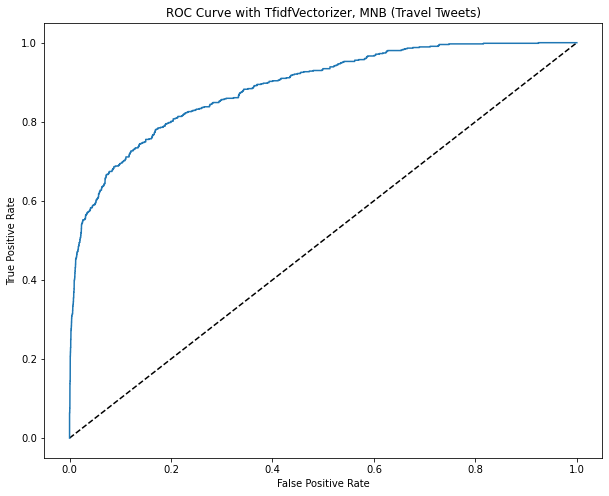

In [22]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_nb)

# Plot ROC curve
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with TfidfVectorizer, MNB (Travel Tweets)')
plt.show()

### Most Predictive Features

In [23]:
words = np.array(tfidf.get_feature_names())

# Create an identity matrix the length of the vocabulary
x = np.eye(X_test_tfidf.shape[1]) 

In [24]:
# Use the model to predict on the identity matrix, and get a list of probabilities for each word
probs = gs_tfidf.predict_log_proba(x)[:,0] 

In [25]:
# Sort for most/least probable words for any give class
ind = np.argsort(probs)

influencer_words = words[ind[:30]]
non_influencer_words = words[ind[-30:]]

influencer_prob = probs[ind[:30]]
non_influencer_prob = probs[ind[-30:]]

print("Influencer words\t     P(influencer | word)")
for w, p in zip(influencer_words, influencer_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Non Influencer words\t     P(Influencer | word)")
for w, p in zip(non_influencer_words, non_influencer_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Influencer words	     P(influencer | word)
    roundtrip travel 1.00
freedomexplorers holiday 0.99
    freedomexplorers 0.99
travel freedomexplorers 0.99
     followers visit 0.99
  scotland followers 0.99
             see end 0.99
      end travelling 0.99
        travel sites 0.99
     top recommended 0.99
          writerlife 0.99
 writerlife bloggers 0.99
     traveller blogs 0.99
       blogging blog 0.99
            blogs rt 0.99
      travel alcohol 0.99
   writer writerlife 0.99
         rt vacation 0.99
       author writer 0.99
     vacation author 0.99
    discount airport 0.98
       parking check 0.98
         big airport 0.98
            save big 0.98
      check discount 0.98
          travel jan 0.97
       tour scotland 0.97
        booking link 0.97
     tbinchat travel 0.97
       dates booking 0.95
Non Influencer words	     P(Influencer | word)
            loscabos 0.00
      puertovallarta 0.00
         travel post 0.00
               drive 0.00
                 sk

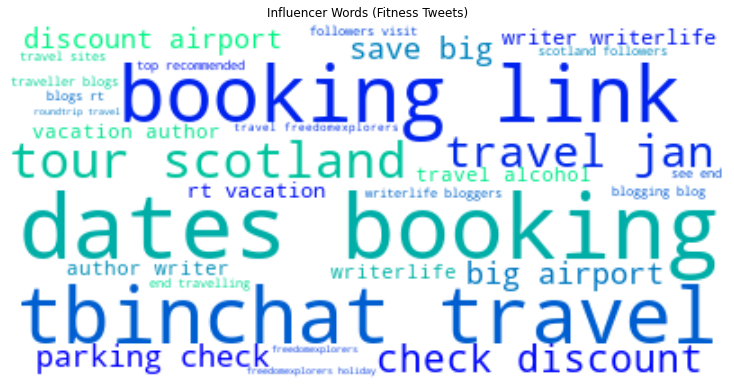

In [26]:
influencer_dict = {}
for w, p in zip(influencer_words, influencer_prob):
    influencer_dict[w] = p

# Generate WordCloud images
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white",colormap='winter').generate_from_frequencies(influencer_dict)

# Display the image
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.title('Influencer Words (Fitness Tweets)')
plt.tight_layout(pad = 0) 

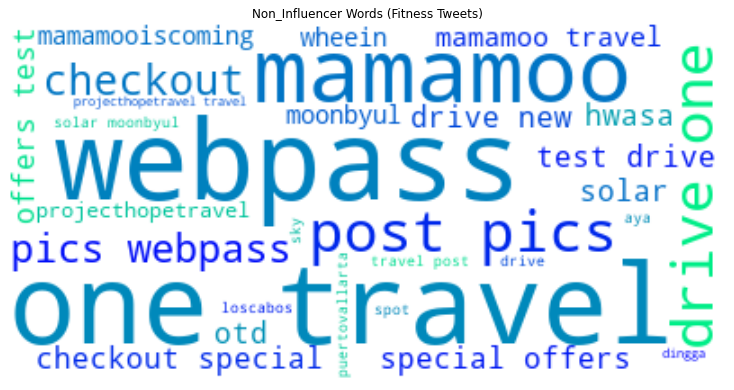

In [27]:
influencer_dict = {}
for w, p in zip(non_influencer_words, non_influencer_prob):
    influencer_dict[w] = p

# Generate WordCloud images
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white",colormap='winter').generate_from_frequencies(influencer_dict)

# Display the image
plt.figure(figsize = (10, 8), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off") 
plt.title('Non_Influencer Words (Fitness Tweets)')
plt.tight_layout(pad = 0) 

### Fit other Classifiers with TFIDF Vectorizer

#### 1. Logistic Regression

In [28]:
# Setup the hyperparameter grid
param_grid = {'C': np.arange(0.05, 4, 0.8),
              'l1_ratio': [0, 1]
              }
# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(max_iter=1000)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs = -1)

# Fit it to the data
logreg_cv.fit(X_train_tfidf, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


Tuned Logistic Regression Parameters: {'C': 3.25, 'l1_ratio': 0}
Best score is 0.8903937687224731


In [29]:
pred_log_clf = logreg_cv.predict(X_test_tfidf)

# Calculate F1 Score
metrics.f1_score(y_test, pred_log_clf)

0.6366307541625856

In [30]:
# Calculate Predicted Probabilities,# keep probabilities for the positive outcome only
pred_prob_log_clf = logreg_cv.predict_proba(X_test_tfidf)[:,1]

# Determine ROC Score
metrics.roc_auc_score(y_test, pred_prob_log_clf)

0.8897079209147475

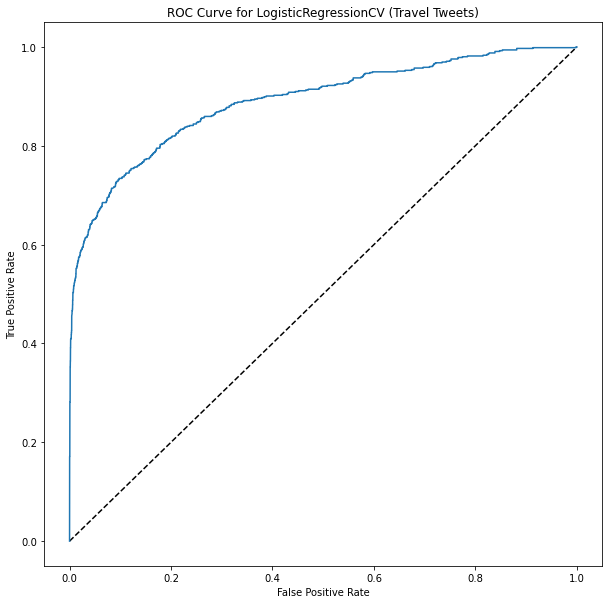

In [31]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred_prob_log_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LogisticRegressionCV (Travel Tweets)')
plt.show()

#### 2. Random Forest

In [32]:
# Instantiate and fit Random Forests Model
rf_clf = RandomForestClassifier(class_weight='balanced',n_jobs = -1).fit(X_train_tfidf, y_train)


pred_rf_clf = rf_clf.predict(X_test_tfidf)

# Calculate F1 Score
metrics.f1_score(y_test, pred_rf_clf)

0.7271062271062271

In [33]:
# Create the parameter grid
parameters = {'max_features': ['sqrt', 'auto'],
              'max_depth': [10, 60, 100, None],
              'n_estimators': [50, 100, 300, 500]
              }

# Instantiate the grid search model
gs_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced'), 
                     parameters, scoring='roc_auc', n_jobs=4, cv=3)

# Fit the grid search to the data
gs_rf.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=4,
             param_grid={'max_depth': [10, 60, 100, None],
                         'max_features': ['sqrt', 'auto'],
                         'n_estimators': [50, 100, 300, 500]},
             scoring='roc_auc')

In [34]:
# Get best parameters and best accuracy score
print('Best Score: ', gs_rf.best_score_)
print('Best Parameters: ', gs_rf.best_params_)

Best Score:  0.9120822078752555
Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 300}


In [35]:
# calculate predicted probabilities # keep probabilities for the positive outcome only
pred_prob_rf_clf = gs_rf.predict_proba(X_test_tfidf)[:, 1]

In [36]:
# Determine ROC score
metrics.roc_auc_score(y_test, pred_prob_rf_clf)

0.9197739780177444

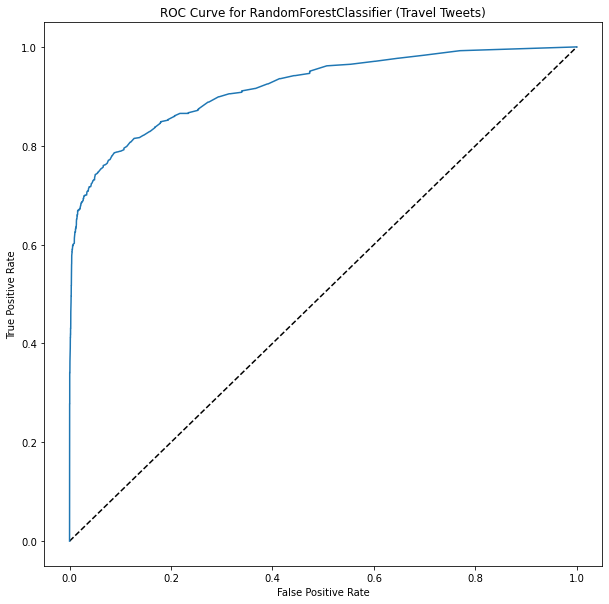

In [37]:
# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred_prob_rf_clf)

# Plot ROC curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--',label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForestClassifier (Travel Tweets)')
plt.show()